<a href="https://colab.research.google.com/github/robertej19/nflows/blob/master/NewMoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/robertej19/nflows.git

Cloning into 'nflows'...
remote: Enumerating objects: 1160, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 1160 (delta 1), reused 7 (delta 1), pack-reused 1141
Receiving objects: 100% (1160/1160), 1.39 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (747/747), done.


In [535]:

#copy files from dropbox 
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-17 23:17:25--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-17 23:17:26--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1019f3252c15412fe4bc7f1881.dl.dropboxusercontent.com/cd/0/inline/BM3gdYQPhoeLKv3vy53rrEneDlE8o0YLUjYVRydn7Xiv-WAK-5Oo-gjwuPpCdj3l7EYgZWeMVs3InvjcC-bO54trxKeczeBR_bBT6T6X80uMvdZPagI_YfamtLffpFtMyy_0a6g3krN4rXMYvrCLiqpT/file# [following]
--2021-04-17 23:17:26--  https://uc1019f3252c15412fe4bc7f1881.dl.dropboxusercontent.com/cd/0/inline/BM3gdYQPhoeLKv3vy53rrEneDlE8o0YLUjYVRydn7Xiv-WAK-5Oo-gjwuPpCdj3l7EYgZWeMVs3InvjcC-bO54trxKeczeBR_bBT

In [536]:
import sys
sys.path.insert(0,'/content/nflows/nflows')

In [538]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [539]:
!pip install nflows

In [541]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.datasets as datasets
import itertools
import numpy as np
%matplotlib inline
from datetime import datetime
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial import distance


import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [543]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        xz = xz[:, 1:]
        x = xz[:, :16]
        z = xz[:, 16:]
        #xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        xwithoutPid = x[:, [0,  4, 8, 12, ]]
        #xwithoutPid = x[:, [0, 1, 4, 5, 8, 12, ]]
        zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        self.zwithoutPid = torch.from_numpy(zwithoutPid)

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        zwithoutPid = self.zwithoutPid[randint]
        return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}

In [545]:
xz = dataXZ()
z = xz.z
x = xz.x

In [547]:
sampleDict = xz.sample(2) 
print(sampleDict["xwithoutPid"])

tensor([[5.1817, 0.6565, 3.7999, 1.3102],
        [6.3517, 1.0938, 3.2752, 0.4324]])


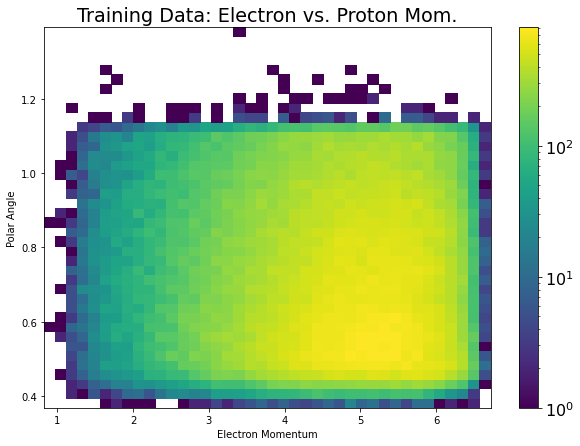

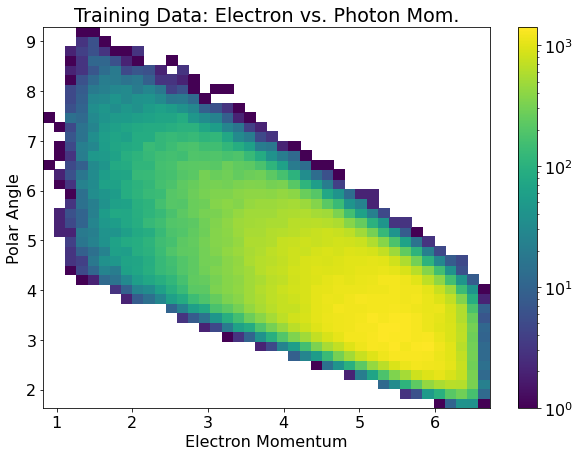

In [548]:
sampleDict = xz.sample(300000) #Get a subset of the datapoints
x = sampleDict["xwithoutPid"][:, 0:12] #For now, only 
#print(x)
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"

ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,2], c='g', s=5)
plt.title('Training Data: Electron vs. Proton Mom.')
x= x.detach().numpy()

plt.hist2d(x[:,0], x[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
#plt.xlim([1,7])
#plt.ylim([0.35,1.2])
plt.colorbar()

fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"

ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
#plt.scatter(x[:,0], x[:,2], c='g', s=5)
plt.title('Training Data: Electron vs. Photon Mom.')


plt.hist2d(x[:,0], x[:,2],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
#plt.xlim([1,7])
#plt.ylim([1.5,9.5])
plt.colorbar()

In [20]:
#x, y = datasets.make_moons(1208, noise=.1)
#plt.scatter(x[:, 0], x[:, 1]);

In [549]:
num_layers = 12
base_dist = StandardNormal(shape=[3])
#base_dist = DiagonalNormal(shape=[3])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=3))
    transforms.append(MaskedAffineAutoregressiveTransform(features=3, 
                                                          hidden_features=12))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())
print("number of params: ", sum(p.numel() for p in flow.parameters()))

number of params:  9000


In [550]:
sampleDict = xz.sample(1000)
x = sampleDict["xwithoutPid"][:, 0:2]
print(type(x))

<class 'torch.Tensor'>


In [551]:
num_iter = 500
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
f1_kd = []
f1_em = []
f1_js = []
f2_em = []
f3_em = []

for i in range(num_iter):
    # x, y = datasets.make_moons(12, noise=.1)
    # x = torch.tensor(x, dtype=torch.float32)
    # print(x)
    # print(y)
    sampleDict = xz.sample(1000)
    x = sampleDict["xwithoutPid"][:, 0:3] 
    #y = sampleDict["xwithoutPid"][:, 1:2] 
    #print(x)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())


    if i % 1 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
        
        bbb = 10000
        z= flow.sample(bbb).detach().numpy()
        sampleDict = xz.sample(bbb)
        x = sampleDict["xwithoutPid"][:, 0:3] 
        x = x.detach().numpy()

        #plot_histo_1D(x,z)

        f1 = meter(x,z,0)
        f2 = meter(x,z,1)
        f3 = meter(x,z,2)

        f1_kd.append(f1[0])
        f1_em.append(f1[1])
        f1_js.append(f1[2])
        f2_em.append(f2[1])
        f3_em.append(f3[1])

        

        #print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
        #print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
        #print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))


now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))
    # if (i + 1) % 50 == 0:
    #     xline = torch.linspace(-1.5, 2.5)
    #     yline = torch.linspace(-.75, 1.25)
    #     xgrid, ygrid = torch.meshgrid(xline, yline)
    #     xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    #     with torch.no_grad():
    #         zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    #     plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    #     plt.title('iteration {}'.format(i + 1))
    #     plt.show()

Start Time = 23:24:05
On step 0 - loss 15.80, Current Running Time = 0.06 seconds
On step 1 - loss 15.60, Current Running Time = 0.60 seconds
On step 2 - loss 15.38, Current Running Time = 0.94 seconds
On step 3 - loss 15.17, Current Running Time = 1.23 seconds
On step 4 - loss 14.97, Current Running Time = 1.54 seconds
On step 5 - loss 14.78, Current Running Time = 1.84 seconds
On step 6 - loss 14.54, Current Running Time = 2.13 seconds
On step 7 - loss 14.32, Current Running Time = 2.43 seconds
On step 8 - loss 14.10, Current Running Time = 2.73 seconds
On step 9 - loss 13.90, Current Running Time = 3.04 seconds
On step 10 - loss 13.67, Current Running Time = 3.35 seconds
On step 11 - loss 13.43, Current Running Time = 3.64 seconds
On step 12 - loss 13.21, Current Running Time = 3.95 seconds
On step 13 - loss 12.98, Current Running Time = 4.32 seconds
On step 14 - loss 12.74, Current Running Time = 4.68 seconds
On step 15 - loss 12.51, Current Running Time = 5.03 seconds
On step 16 -

Text(0, 0.5, 'Kullback–Leibler Divergence')

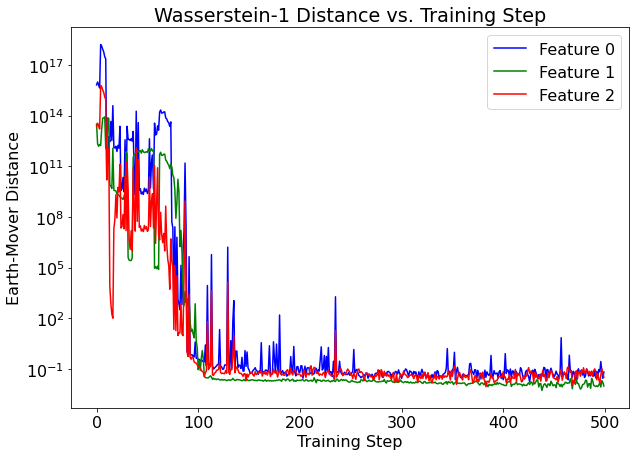

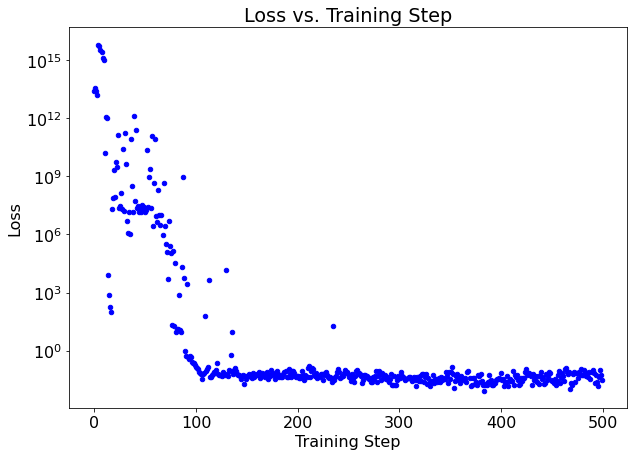

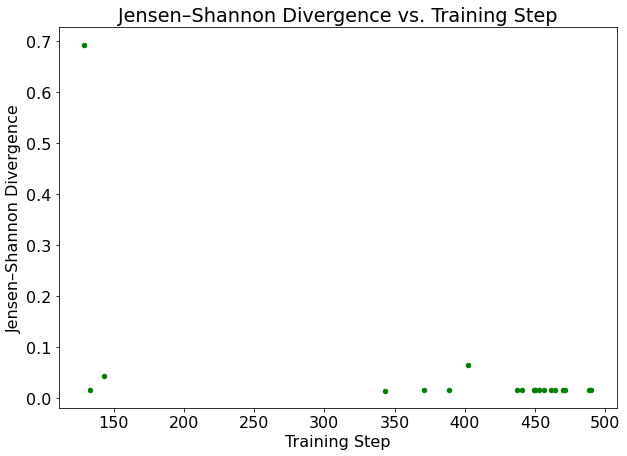

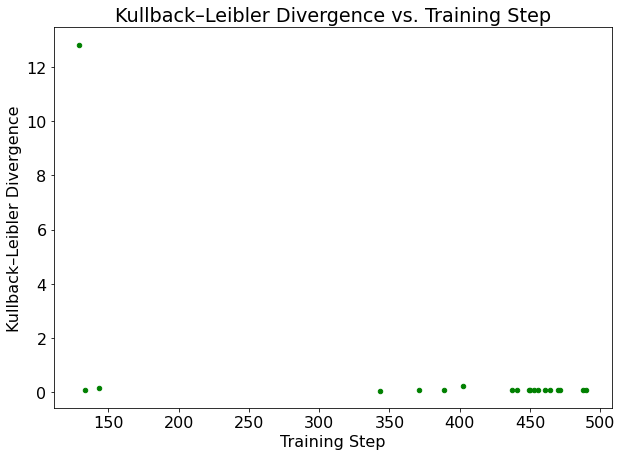

In [559]:
#f1_kd = []
#f1_em = []
#f1_js = []

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.plot(np.arange(len(f1_em)),f1_em, '-b',label="Feature 0")
plt.plot(np.arange(len(f1_em)),f2_em, '-g',label="Feature 1")
plt.plot(np.arange(len(f1_em)),f3_em, '-r',label="Feature 2")
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Wasserstein-1 Distance vs. Training Step')
ax.legend()
ax.set_xlabel("Training Step")  
ax.set_ylabel("Earth-Mover Distance")


fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_em)),f3_em, c='b', s=20)
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_js)),f1_js, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Jensen–Shannon Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Jensen–Shannon Divergence")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_kd)),f1_kd, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Kullback–Leibler Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Kullback–Leibler Divergence")



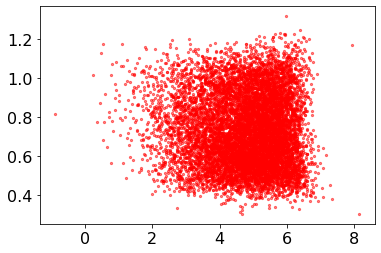

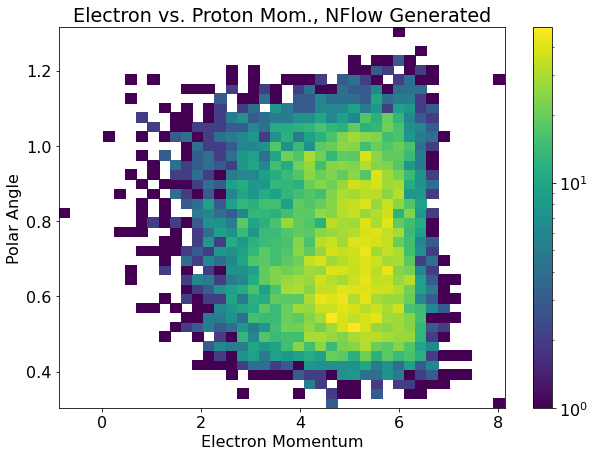

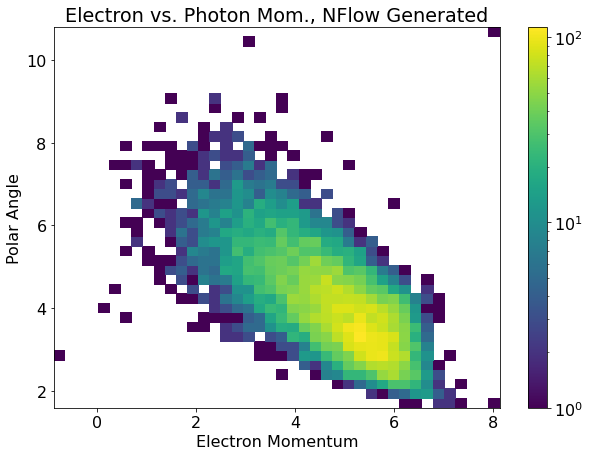

In [553]:
aa = flow.sample(10000).detach().numpy()

plt.scatter(aa[:,0], aa[:,1], c='r', s=5, alpha=0.5)

z = aa
fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron vs. Proton Mom., NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,1],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
#plt.xlim([1,7])
#plt.ylim([.35,1.2])
plt.colorbar()

fig, ax = plt.subplots(figsize =(10, 7)) 
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Polar Angle")
plt.title('Electron vs. Photon Mom., NFlow Generated')
#plt.scatter(x[:,0], x[:,1], c='g', s=5)
plt.hist2d(z[:,0], z[:,2],bins =[40, 40],norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
#plt.xlim([1,7])
#plt.ylim([1.5,9.5])
plt.colorbar()

In [554]:
def plot_histo_1D(real_vals, gen_vals, label_real="Physics Data", label_gen="NFlow Model", col2 = "skyblue",title="Physics vs NFlow Models", saveloc=None):
    fig, axes = plt.subplots(1, 3, figsize=(3*5, 5))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(real_vals[:, INDEX], bins=100, color = "orange", label=label_real, density=True)
        ax.hist(gen_vals[:, INDEX], bins=bins, label=label_gen, color = col2,alpha=0.7, density=True)
        ax.legend()
        ax.set_title("Feature {}".format(INDEX) )
    plt.tight_layout()
    if saveloc is not None: plt.savefig(saveloc)
    plt.show()

def meter(dist1,dist2,feature):
  kld = entropy(dist1[:,feature],dist2[:,feature])
  emd = wasserstein_distance(dist1[:,feature],dist2[:,feature])
  jsd = distance.jensenshannon(dist1[:,feature],dist2[:,feature]) ** 2
  return [kld, emd, jsd]

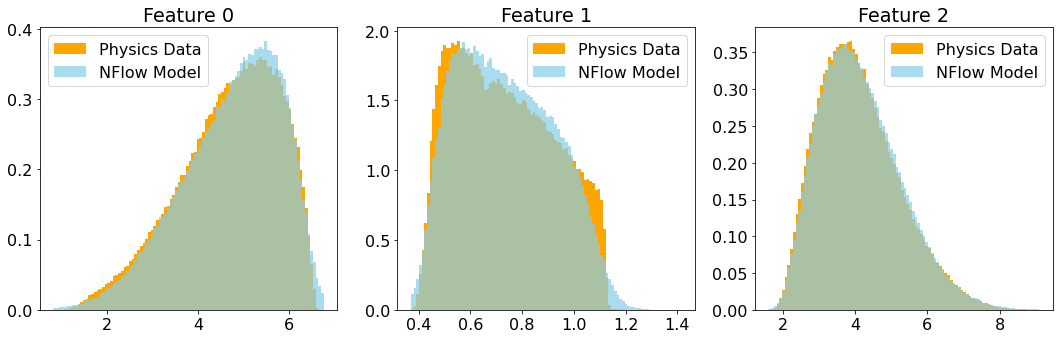

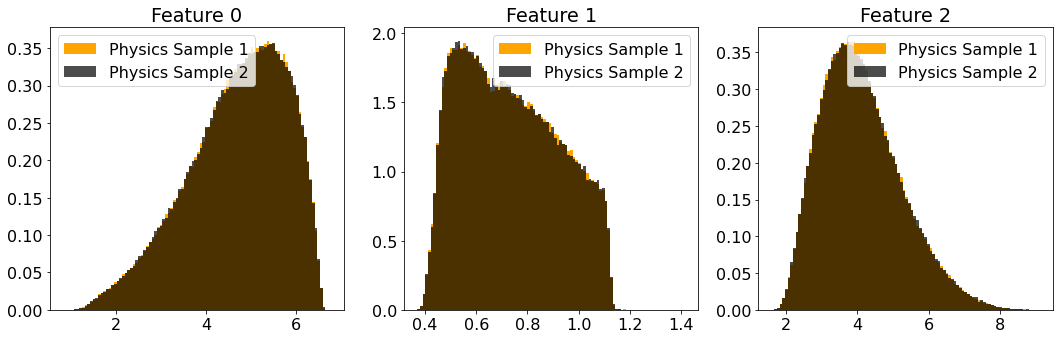

Values for Physics Data vs. NFlow Model:
KL Divergence Values: F0: inf  F1: 0.06639  F2: 0.07321 
EM Distance   Values: F0: 0.10019  F1: 0.00822  F2: 0.03774 
JS Divergence Values: F0: inf  F1: 0.01635  F2: 0.01800 


Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:
KL Divergence Values: F0: inf  F1: 0.97704  F2: 0.99699 
EM Distance   Values: F0: 48.43580  F1: 13.63187  F2: 11.49151 
JS Divergence Values: F0: inf  F1: 0.97626  F2: 0.99688 


Values for two samples from physics data
KL Divergence Values: F0: 0.06270  F1: 0.06795  F2: 0.07343 
EM Distance   Values: F0: 0.00207  F1: 0.00060  F2: 0.00328 
JS Divergence Values: F0: 0.01535  F1: 0.01675  F2: 0.01805 


In [555]:


bbb = 400000
z= flow.sample(bbb).detach().numpy()
sampleDict = xz.sample(bbb)
sampleDict2 = xz.sample(bbb)
y = sampleDict2["xwithoutPid"][:, 0:3] 
y = y.detach().numpy()
x = sampleDict["xwithoutPid"][:, 0:3] 
x = x.detach().numpy()

plot_histo_1D(x,z)
plot_histo_1D(x,y,label_real="Physics Sample 1", label_gen="Physics Sample 2",col2="black")

f1 = meter(x,z,0)
f2 = meter(x,z,1)
f3 = meter(x,z,2)
print("Values for Physics Data vs. NFlow Model:")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))
print('\n')

f1 = [i / j for i, j in zip(f1,meter(x,y,0))]
f2 = [i / j for i, j in zip(f2,meter(x,y,1))]
f3 = [i / j for i, j in zip(f3,meter(x,y,2))]

print("Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))
print('\n')

f1 = meter(x,y,0)
f2 = meter(x,y,1)
f3 = meter(x,y,2)
print("Values for two samples from physics data")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))


